# Training a variational autoencoder on an image dataset and using it to generate images

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
# Load the CIFAR-10 dataset
(xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
xTrain = xTrain.astype('float32') / 255.0
xTest = xTest.astype('float32') / 255.0

# Split the training data into training and validation sets
validationSplit = 0.2
numValidationSamples = int(validationSplit * xTrain.shape[0])

xValid = xTrain[:numValidationSamples]
yValid = yTrain[:numValidationSamples]

xTrainFull = xTrain[numValidationSamples:]
yTrainFull = yTrain[numValidationSamples:]

print(f"Training data shape: {xTrainFull.shape}")
print(f"Training labels shape: {yTrainFull.shape}")
print(f"Validation data shape: {xValid.shape}")
print(f"Validation labels shape: {yValid.shape}")
print(f"Test data shape: {xTest.shape}")
print(f"Test labels shape: {yTest.shape}")

# CIFAR-10 class names for reference
classNames = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

Training data shape: (40000, 32, 32, 3)
Training labels shape: (40000, 1)
Validation data shape: (10000, 32, 32, 3)
Validation labels shape: (10000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


In [4]:
tf.random.set_seed(42)

In [5]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        mean, log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_sum(
            1 + log_var - tf.exp(log_var) - tf.square(mean),
            axis=-1)
        kl_loss = tf.reduce_mean(kl_loss) / (32 * 32 * 3)
        beta = 0.33 # Try values < 1.0 first, like 0.1, 0.25, 0.5
        self.add_loss(beta * kl_loss)
        return reconstructed

In [6]:
# Encoder

codings_size = 64

inputs = tf.keras.layers.Input(shape=[32, 32, 3])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(1024, activation="relu")(Z)
Z = tf.keras.layers.Dense(512, activation="relu")(Z)
Z = tf.keras.layers.Dense(256, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [7]:
# Decoder

decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(256, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(512, activation="relu")(x)
Z = tf.keras.layers.Dense(1024, activation="relu")(Z)
x = tf.keras.layers.Dense(32 * 32 * 3, activation="sigmoid")(x)
outputs = tf.keras.layers.Reshape([32, 32, 3])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [8]:
variational_ae = VAE(variational_encoder, variational_decoder)

In [9]:
variational_ae.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Nadam())
history = variational_ae.fit(xTrainFull, xTrainFull, epochs=50, batch_size=128,
                             validation_data=(xValid, xValid))

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.6607 - val_loss: 0.6287
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.6275 - val_loss: 0.6167
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6166 - val_loss: 0.6123
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.6123 - val_loss: 0.6076
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.6089 - val_loss: 0.6105
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.6075 - val_loss: 0.6040
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6051 - val_loss: 0.6039
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.6035 - val_loss: 0.6021
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.6022 - val_loss: 0.6006
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.6017 - val_loss: 0.5997
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.6004 - val_loss: 0.6006
Epoch 12/50
313/313 ━━━━━━━━━━━━━━━━━━━━

In [10]:
def plot_reconstructions(model, images=xValid, n_images=5):
    reconstructions = model.predict(images[:n_images])

    reconstructions = np.clip(reconstructions, 0.0, 1.0) 

    plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        # Plot Original Image
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index]) 
        plt.title(f"Orig {image_index+1}")
        plt.axis("off")

        # Plot Reconstructed Image
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index])
        plt.title(f"Recon {image_index+1}")
        plt.axis("off")

    plt.suptitle("Original vs. Reconstructed Images")
    plt.tight_layout()
    plt.show()

def generate_samples(decoder, num_samples=5):
    random_latent_vectors = tf.random.normal(shape=(num_samples, codings_size))
    generated_images = decoder(random_latent_vectors)
    return generated_images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


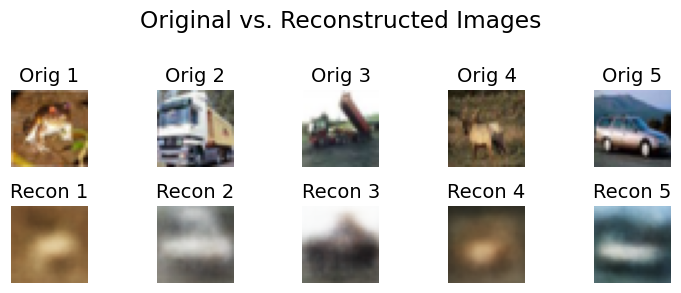

In [11]:
plot_reconstructions(variational_ae, images=xValid, n_images=5)

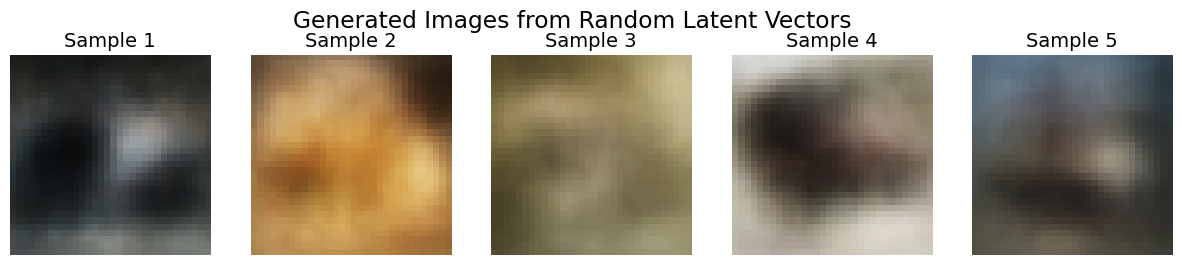

In [12]:
num_samples_to_generate = 5
generated_images = generate_samples(variational_decoder, num_samples_to_generate)

plt.figure(figsize=(15, 3))
for i in range(num_samples_to_generate):
    ax = plt.subplot(1, num_samples_to_generate, i + 1)
    img_display = generated_images[i].numpy()
    plt.imshow(img_display)
    plt.title(f"Sample {i+1}")
    plt.axis("off")
plt.suptitle("Generated Images from Random Latent Vectors")
plt.show()